How to run this

You need to upload this file and BloodSmear.zip to google drive, (/drive/myDrvive) when drive is mounted, it will unzip files into collab contents.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import os.path
from pathlib import Path
import glob

In [4]:
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import keras
# from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

In [7]:
from keras.optimizers import RMSprop,Adam,Optimizer,Optimizer

In [8]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D
from keras import models
from keras import layers
import tensorflow as tf
from keras.applications import VGG16,VGG19,inception_v3
from keras import backend as K

In [9]:
from zipfile import ZipFile as zf, BadZipFile

# Ensure the file path is correct and the file exists
file_path = "/content/drive/MyDrive/Blood-Smear.zip"

# Add error handling to provide more context
try:
    with zf(file_path, "r") as zip_ref:
        zip_ref.extractall("/content/BloodSmearSamples")
except FileNotFoundError:
    print(f"Error: File not found at path: {file_path}")
except BadZipFile: # Now BadZipFile is defined
    print(f"Error: Invalid or corrupted zip file at path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [10]:
import os
import shutil
import random

def split_data(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1"

    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if not os.path.isdir(category_path):
            continue  # Skip non-directory files

        images = os.listdir(category_path)
        random.shuffle(images)

        train_split = int(train_ratio * len(images))
        val_split = int(val_ratio * len(images)) + train_split

        sets = {'train': images[:train_split], 'val': images[train_split:val_split], 'test': images[val_split:]}

        for set_name, set_images in sets.items():
            dest_folder = os.path.join(output_dir, set_name, category)
            os.makedirs(dest_folder, exist_ok=True)

            for img in set_images:
                shutil.copy(os.path.join(category_path, img), os.path.join(dest_folder, img))

source_folder = "/content/BloodSmearSamples"
output_folder = "/content/SplitBloodSmearSamples"
split_data(source_folder, output_folder)


In [11]:
Train_Data_Path = Path("/content/SplitBloodSmearSamples/train")

In [12]:
Test_Data_Path = Path("/content/SplitBloodSmearSamples/test")

In [13]:
Validation_Data_Path = Path("/content/SplitBloodSmearSamples/val")

In [19]:
Train_JPG_Path = list(Train_Data_Path.glob(r"**/*.jpg"))

In [20]:
Test_JPG_Path = list(Test_Data_Path.glob(r"**/*.jpg"))

In [34]:
Val_JPG_Path = list(Validation_Data_Path.glob(r"**/*.jpg"))

In [22]:
Train_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Train_JPG_Path))

In [23]:
print("Benign: ", Train_JPG_Labels.count("Benign"))
print("[Malignant] Pre-B: ", Train_JPG_Labels.count("[Malignant] Pre-B"))
print("[Malignant] Pro-B: ", Train_JPG_Labels.count("[Malignant] Pro-B"))
print("[Malignant] early Pre-B: ", Train_JPG_Labels.count("[Malignant] early Pre-B"))

Benign:  358
[Malignant] Pre-B:  668
[Malignant] Pro-B:  557
[Malignant] early Pre-B:  685


In [24]:
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))

In [26]:
print("Benign: ", Test_JPG_Labels.count("Benign"))
print("[Malignant] Pre-B: ", Test_JPG_Labels.count("[Malignant] Pre-B"))
print("[Malignant] Pro-B: ", Test_JPG_Labels.count("[Malignant] Pro-B"))
print("[Malignant] early Pre-B: ", Test_JPG_Labels.count("[Malignant] early Pre-B"))

Benign:  78
[Malignant] Pre-B:  144
[Malignant] Pro-B:  120
[Malignant] early Pre-B:  148


In [75]:
Val_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Val_JPG_Path))

In [28]:
print("Benign: ", Val_JPG_Labels.count("Benign"))
print("[Malignant] Pre-B: ", Val_JPG_Labels.count("[Malignant] Pre-B"))
print("[Malignant] Pro-B: ", Val_JPG_Labels.count("[Malignant] Pro-B"))
print("[Malignant] early Pre-B: ", Val_JPG_Labels.count("[Malignant] early Pre-B"))

Benign:  76
[Malignant] Pre-B:  143
[Malignant] Pro-B:  119
[Malignant] early Pre-B:  146


In [78]:
Train_JPG_Path_Series = pd.Series(Train_JPG_Path,name="JPG").astype(str)

In [79]:
Train_JPG_Labels_Series = pd.Series(Train_JPG_Labels,name="CATEGORY")

In [80]:
Test_JPG_Path_Series = pd.Series(Test_JPG_Path,name="JPG").astype(str)

In [81]:
Test_JPG_Labels_Series = pd.Series(Test_JPG_Labels,name="CATEGORY")

In [82]:
Val_JPG_Path_Series = pd.Series(Val_JPG_Path,name="JPG").astype(str)

In [83]:
Validation_JPG_Labels_Series = pd.Series(Val_JPG_Labels,name="CATEGORY")

In [84]:
Main_Train_Data = pd.concat([Train_JPG_Path_Series,Train_JPG_Labels_Series],axis=1)

In [85]:
print(Main_Train_Data.head(-1))

                                                    JPG           CATEGORY
0     /content/SplitBloodSmearSamples/train/[Maligna...  [Malignant] Pro-B
1     /content/SplitBloodSmearSamples/train/[Maligna...  [Malignant] Pro-B
2     /content/SplitBloodSmearSamples/train/[Maligna...  [Malignant] Pro-B
3     /content/SplitBloodSmearSamples/train/[Maligna...  [Malignant] Pro-B
4     /content/SplitBloodSmearSamples/train/[Maligna...  [Malignant] Pro-B
...                                                 ...                ...
2262  /content/SplitBloodSmearSamples/train/Benign/S...             Benign
2263  /content/SplitBloodSmearSamples/train/Benign/S...             Benign
2264  /content/SplitBloodSmearSamples/train/Benign/S...             Benign
2265  /content/SplitBloodSmearSamples/train/Benign/S...             Benign
2266  /content/SplitBloodSmearSamples/train/Benign/S...             Benign

[2267 rows x 2 columns]


In [86]:
Main_Test_Data = pd.concat([Test_JPG_Path_Series,Test_JPG_Labels_Series],axis=1)

In [87]:
print(Main_Test_Data.head(-1))

                                                   JPG           CATEGORY
0    /content/SplitBloodSmearSamples/test/[Malignan...  [Malignant] Pro-B
1    /content/SplitBloodSmearSamples/test/[Malignan...  [Malignant] Pro-B
2    /content/SplitBloodSmearSamples/test/[Malignan...  [Malignant] Pro-B
3    /content/SplitBloodSmearSamples/test/[Malignan...  [Malignant] Pro-B
4    /content/SplitBloodSmearSamples/test/[Malignan...  [Malignant] Pro-B
..                                                 ...                ...
484  /content/SplitBloodSmearSamples/test/Benign/Sn...             Benign
485  /content/SplitBloodSmearSamples/test/Benign/Sn...             Benign
486  /content/SplitBloodSmearSamples/test/Benign/Sa...             Benign
487  /content/SplitBloodSmearSamples/test/Benign/Sn...             Benign
488  /content/SplitBloodSmearSamples/test/Benign/Sn...             Benign

[489 rows x 2 columns]


In [88]:
Main_Validation_Data = pd.concat([Val_JPG_Path_Series,Validation_JPG_Labels_Series],axis=1)

In [89]:
print(Main_Validation_Data.head(-1))

                                                   JPG           CATEGORY
0    /content/SplitBloodSmearSamples/val/[Malignant...  [Malignant] Pro-B
1    /content/SplitBloodSmearSamples/val/[Malignant...  [Malignant] Pro-B
2    /content/SplitBloodSmearSamples/val/[Malignant...  [Malignant] Pro-B
3    /content/SplitBloodSmearSamples/val/[Malignant...  [Malignant] Pro-B
4    /content/SplitBloodSmearSamples/val/[Malignant...  [Malignant] Pro-B
..                                                 ...                ...
478  /content/SplitBloodSmearSamples/val/Benign/Sna...             Benign
479  /content/SplitBloodSmearSamples/val/Benign/Sna...             Benign
480  /content/SplitBloodSmearSamples/val/Benign/Sap...             Benign
481  /content/SplitBloodSmearSamples/val/Benign/Sna...             Benign
482  /content/SplitBloodSmearSamples/val/Benign/Sna...             Benign

[483 rows x 2 columns]


In [90]:
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)

In [91]:
print(Main_Train_Data.head(-1))

                                                    JPG  \
0     /content/SplitBloodSmearSamples/train/Benign/S...   
1     /content/SplitBloodSmearSamples/train/Benign/S...   
2     /content/SplitBloodSmearSamples/train/[Maligna...   
3     /content/SplitBloodSmearSamples/train/Benign/S...   
4     /content/SplitBloodSmearSamples/train/[Maligna...   
...                                                 ...   
2262  /content/SplitBloodSmearSamples/train/[Maligna...   
2263  /content/SplitBloodSmearSamples/train/[Maligna...   
2264  /content/SplitBloodSmearSamples/train/Benign/S...   
2265  /content/SplitBloodSmearSamples/train/[Maligna...   
2266  /content/SplitBloodSmearSamples/train/[Maligna...   

                     CATEGORY  
0                      Benign  
1                      Benign  
2     [Malignant] early Pre-B  
3                      Benign  
4     [Malignant] early Pre-B  
...                       ...  
2262        [Malignant] Pre-B  
2263        [Malignant] Pro-B  
226

In [92]:
Main_Test_Data = Main_Test_Data.sample(frac=1).reset_index(drop=True)

In [93]:
print(Main_Test_Data.head(-1))

                                                   JPG  \
0    /content/SplitBloodSmearSamples/test/[Malignan...   
1    /content/SplitBloodSmearSamples/test/[Malignan...   
2    /content/SplitBloodSmearSamples/test/[Malignan...   
3    /content/SplitBloodSmearSamples/test/[Malignan...   
4    /content/SplitBloodSmearSamples/test/[Malignan...   
..                                                 ...   
484  /content/SplitBloodSmearSamples/test/[Malignan...   
485  /content/SplitBloodSmearSamples/test/[Malignan...   
486  /content/SplitBloodSmearSamples/test/[Malignan...   
487  /content/SplitBloodSmearSamples/test/[Malignan...   
488  /content/SplitBloodSmearSamples/test/[Malignan...   

                    CATEGORY  
0          [Malignant] Pro-B  
1    [Malignant] early Pre-B  
2    [Malignant] early Pre-B  
3          [Malignant] Pro-B  
4    [Malignant] early Pre-B  
..                       ...  
484  [Malignant] early Pre-B  
485        [Malignant] Pre-B  
486        [Malignant] P

In [94]:
Main_Validation_Data = Main_Validation_Data.sample(frac=1).reset_index(drop=True)

In [95]:
print(Main_Validation_Data.head(-1))

                                                   JPG  \
0    /content/SplitBloodSmearSamples/val/[Malignant...   
1    /content/SplitBloodSmearSamples/val/Benign/Sna...   
2    /content/SplitBloodSmearSamples/val/Benign/Sna...   
3    /content/SplitBloodSmearSamples/val/[Malignant...   
4    /content/SplitBloodSmearSamples/val/Benign/Sna...   
..                                                 ...   
478  /content/SplitBloodSmearSamples/val/[Malignant...   
479  /content/SplitBloodSmearSamples/val/[Malignant...   
480  /content/SplitBloodSmearSamples/val/[Malignant...   
481  /content/SplitBloodSmearSamples/val/[Malignant...   
482  /content/SplitBloodSmearSamples/val/[Malignant...   

                    CATEGORY  
0    [Malignant] early Pre-B  
1                     Benign  
2                     Benign  
3    [Malignant] early Pre-B  
4                     Benign  
..                       ...  
478  [Malignant] early Pre-B  
479        [Malignant] Pro-B  
480        [Malignant] P

In [96]:
plt.style.use('dark_background')

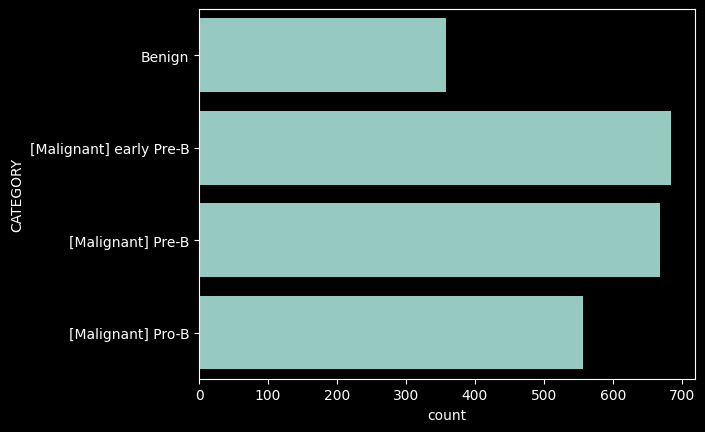

In [97]:
sns.countplot(Main_Train_Data["CATEGORY"])
plt.show()

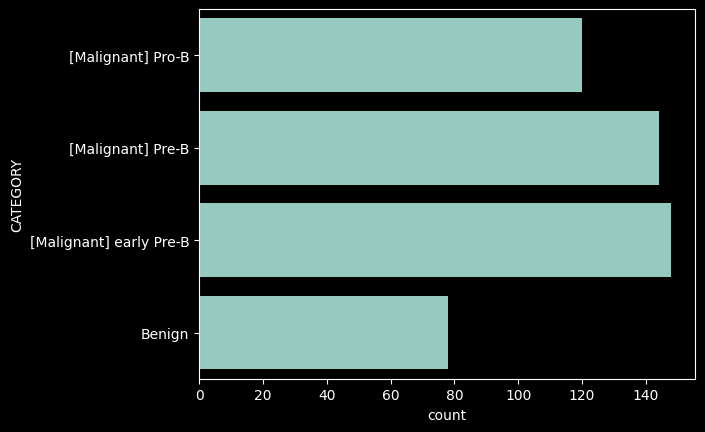

In [70]:
sns.countplot(Main_Test_Data["CATEGORY"])
plt.show()

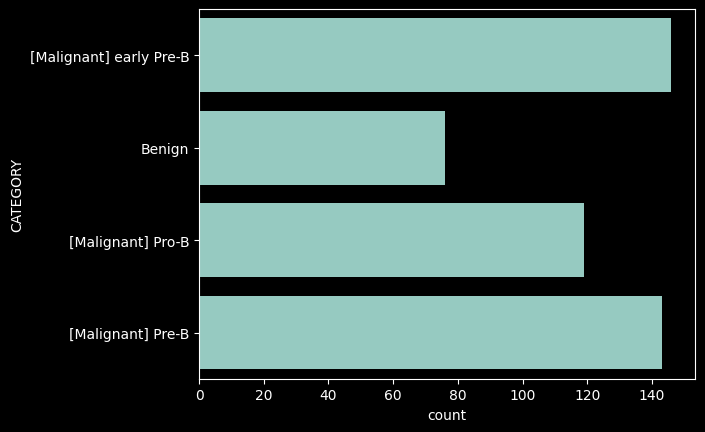

In [98]:
sns.countplot(Main_Validation_Data["CATEGORY"])
plt.show()

In [99]:
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    zoom_range=0.3,
                                    shear_range=0.3,
                                    rotation_range=40,
                                    horizontal_flip=True,
                                    fill_mode="nearest")

In [100]:
Test_Validation_Generator = ImageDataGenerator(rescale=1./255,validation_split=0.5)

In [101]:
exp_IMG = Main_Train_Data["JPG"][22]
Load_IMG = image.load_img(exp_IMG,target_size=(220,220))
Array_IMG = image.img_to_array(Load_IMG)
Array_IMG = Array_IMG.reshape((1,) + Array_IMG.shape)

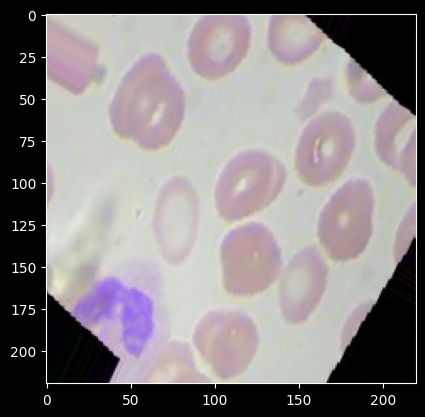

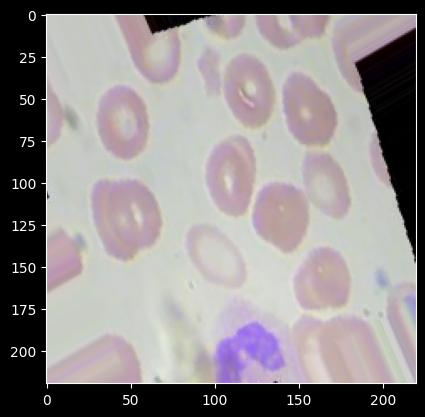

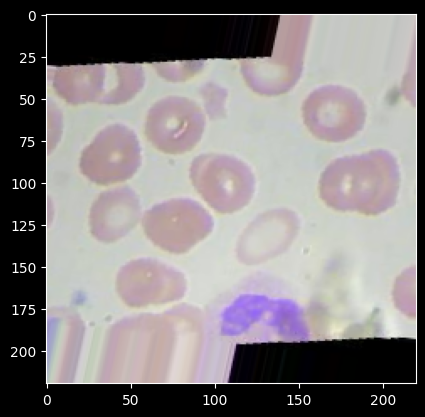

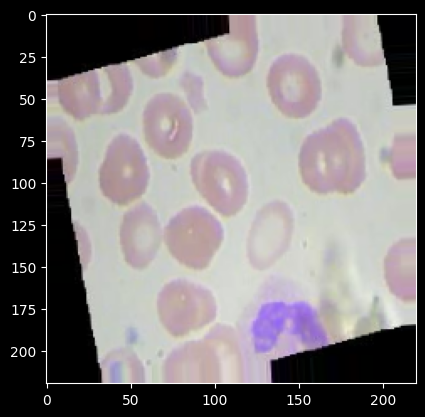

In [ ]:
i = 0
for batch in Train_Generator.flow(Array_IMG,batch_size=1):
    plt.figure(i)
    IMG = plt.imshow(image.img_to_array(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [102]:
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Main_Train_Data,
                                                   x_col="JPG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   subset="training",
                                                   seed=42,
                                                   batch_size=32,
                                                   target_size=(220,220))

Found 2268 validated image filenames belonging to 4 classes.


In [103]:
Test_IMG_Set = Test_Validation_Generator.flow_from_dataframe(dataframe=Main_Test_Data,
                                                            x_col="JPG",
                                                            y_col="CATEGORY",
                                                            color_mode="rgb",
                                                            class_mode="categorical",
                                                            seed=42,
                                                            batch_size=32,
                                                            target_size=(220,220))

Found 490 validated image filenames belonging to 4 classes.


In [104]:
Validation_IMG_Set = Test_Validation_Generator.flow_from_dataframe(dataframe=Main_Validation_Data,
                                                                  x_col="JPG",
                                                                  y_col="CATEGORY",
                                                                  color_mode="rgb",
                                                                  class_mode="categorical",
                                                                  seed=42,
                                                                  batch_Size=32,
                                                                  target_size=(220,200),
                                                                  subset="validation")

Found 242 validated image filenames belonging to 4 classes.


In [105]:
for data_batch,label_batch in Train_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 220, 220, 3)
LABEL SHAPE:  (32, 4)


In [106]:
for data_batch,label_batch in Validation_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 220, 200, 3)
LABEL SHAPE:  (32, 4)


In [107]:
for data_batch,label_batch in Test_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 220, 220, 3)
LABEL SHAPE:  (32, 4)


In [108]:
Model = Sequential()

Model.add(SeparableConv2D(32,3,
                          activation="relu",
                 input_shape=(220,220,3)))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2)))

#
Model.add(SeparableConv2D(64,3,
                 activation="relu"))
Model.add(SeparableConv2D(128,(3,3),
                 activation="relu"))
Model.add(Dropout(0.5))
Model.add(MaxPooling2D((2)))

#
Model.add(SeparableConv2D(64,3,
                 activation="relu"))
Model.add(SeparableConv2D(128,3,
                 activation="relu"))
Model.add(Dropout(0.5))
Model.add(GlobalAveragePooling2D())

#
Model.add(Flatten())
Model.add(Dense(256,
                activation="relu"))
Model.add(Dropout(0.5))
Model.add(Dense(4,
                activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [109]:
Call_Back = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5,mode="max")

In [110]:
Model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

In [116]:
CNN_Model = Model.fit(Train_IMG_Set,
                      validation_data=Validation_IMG_Set,
                            callbacks=Call_Back,
                      epochs=50)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 424s 6s/step - accuracy: 0.7861 - loss: 0.5532 - val_accuracy: 0.4587 - val_loss: 1.2198
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.8143 - loss: 0.4709 - val_accuracy: 0.5083 - val_loss: 1.2729
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 417s 6s/step - accuracy: 0.8280 - loss: 0.4084 - val_accuracy: 0.5083 - val_loss: 1.3736
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 417s 6s/step - accuracy: 0.8405 - loss: 0.4197 - val_accuracy: 0.7562 - val_loss: 0.6334
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 441s 6s/step - accuracy: 0.8474 - loss: 0.3791 - val_accuracy: 0.7851 - val_loss: 0.4870
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.8585 - loss: 0.3728 - val_accuracy: 0.8223 - val_loss: 0.4500
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 452s 6s/step - accuracy: 0.8720 - loss: 0.3404 - val_accuracy: 0.7686 - val_loss: 0.5176
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 416s 6s/step - accuracy: 0.8759 - loss: 0.3432 - val_accuracy: 0.8678 - v

In [ ]:
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 424s 6s/step - accuracy: 0.7861 - loss: 0.5532 - val_accuracy: 0.4587 - val_loss: 1.2198
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.8143 - loss: 0.4709 - val_accuracy: 0.5083 - val_loss: 1.2729
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 417s 6s/step - accuracy: 0.8280 - loss: 0.4084 - val_accuracy: 0.5083 - val_loss: 1.3736
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 417s 6s/step - accuracy: 0.8405 - loss: 0.4197 - val_accuracy: 0.7562 - val_loss: 0.6334
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 441s 6s/step - accuracy: 0.8474 - loss: 0.3791 - val_accuracy: 0.7851 - val_loss: 0.4870
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.8585 - loss: 0.3728 - val_accuracy: 0.8223 - val_loss: 0.4500
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 452s 6s/step - accuracy: 0.8720 - loss: 0.3404 - val_accuracy: 0.7686 - val_loss: 0.5176
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 416s 6s/step - accuracy: 0.8759 - loss: 0.3432 - val_accuracy: 0.8678 - val_loss: 0.3539
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 428s 6s/step - accuracy: 0.8885 - loss: 0.2975 - val_accuracy: 0.8306 - val_loss: 0.3528
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 428s 6s/step - accuracy: 0.8848 - loss: 0.3322 - val_accuracy: 0.8140 - val_loss: 0.4086
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 419s 6s/step - accuracy: 0.8834 - loss: 0.3101 - val_accuracy: 0.8760 - val_loss: 0.2978
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.9139 - loss: 0.2549 - val_accuracy: 0.6364 - val_loss: 0.7505
Epoch 13/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 417s 6s/step - accuracy: 0.9006 - loss: 0.2626 - val_accuracy: 0.8512 - val_loss: 0.4417
Epoch 14/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 427s 6s/step - accuracy: 0.9175 - loss: 0.2234 - val_accuracy: 0.9298 - val_loss: 0.2298
Epoch 15/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.9166 - loss: 0.2386 - val_accuracy: 0.9215 - val_loss: 0.2104
Epoch 16/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 416s 6s/step - accuracy: 0.9185 - loss: 0.2339 - val_accuracy: 0.7810 - val_loss: 0.6640
Epoch 17/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 442s 6s/step - accuracy: 0.9174 - loss: 0.2287 - val_accuracy: 0.9339 - val_loss: 0.2032
Epoch 18/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 419s 6s/step - accuracy: 0.9377 - loss: 0.2121 - val_accuracy: 0.6281 - val_loss: 0.7777
Epoch 19/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 440s 6s/step - accuracy: 0.9274 - loss: 0.2077 - val_accuracy: 0.9711 - val_loss: 0.1487
Epoch 20/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 419s 6s/step - accuracy: 0.9451 - loss: 0.1613 - val_accuracy: 0.9587 - val_loss: 0.1411
Epoch 21/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 440s 6s/step - accuracy: 0.9389 - loss: 0.1650 - val_accuracy: 0.9504 - val_loss: 0.2074
Epoch 22/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 417s 6s/step - accuracy: 0.9504 - loss: 0.1445 - val_accuracy: 0.9298 - val_loss: 0.1919
Epoch 23/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 417s 6s/step - accuracy: 0.9532 - loss: 0.1330 - val_accuracy: 0.4504 - val_loss: 1.3039
Epoch 24/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.9525 - loss: 0.1374 - val_accuracy: 0.8347 - val_loss: 0.5024

In [ ]:
# model.evaluate
# LOSS:  0.2998
# ACCURACY:  0.85

In [112]:
import os
import cv2
import numpy as np

# Define the dataset image paths
image_folders = [
    "/content/SplitBloodSmearSamples/train",
    "/content/SplitBloodSmearSamples/test",
    "/content/SplitBloodSmearSamples/val",
]

# Initialize empty lists to store the information
sizes = []
resolutions = []
color_distributions = []

# Iterate over each folder in the dataset
for root_path in image_folders:
    for dirpath, dirnames, filenames in os.walk(root_path):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure image files only
                # Load the image using OpenCV
                img_path = os.path.join(dirpath, filename)
                img = cv2.imread(img_path)

                if img is None:
                    print(f"Skipping unreadable image: {img_path}")
                    continue  # Skip unreadable images

                # Extract the size of the image (in bytes)
                size = os.path.getsize(img_path)
                sizes.append(size)

                # Extract the resolution (height, width)
                resolution = img.shape[:2]
                resolutions.append(resolution)

                # Extract the color distribution (flatten image into 1D array and count pixel values)
                color_distribution = np.bincount(img.flatten(), minlength=256)
                color_distributions.append(color_distribution)

# Convert lists to numpy arrays for easier manipulation
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)

# Print summary statistics
print(f"Total Images Processed: {len(sizes)}")
print(f"Average Image Size: {np.mean(sizes) / 1024:.2f} KB")
print(f"Unique Resolutions: {np.unique(resolutions, axis=0)}")


Total Images Processed: 3242
Average Image Size: 544.58 KB
Unique Resolutions: [[ 768 1024]
 [1920 2560]]


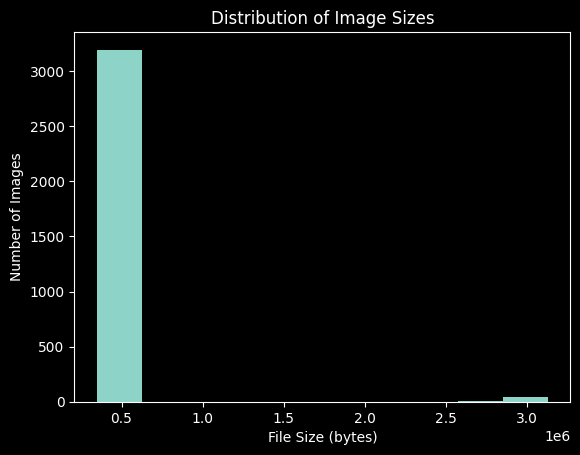

In [113]:
import matplotlib.pyplot as plt

# Plot a histogram of the image sizes
plt.hist(sizes)
plt.title("Distribution of Image Sizes")
plt.xlabel("File Size (bytes)")
plt.ylabel("Number of Images")
plt.show()

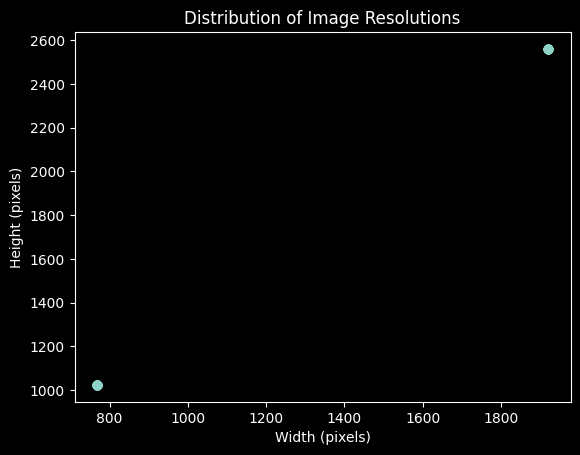

In [114]:
import matplotlib.pyplot as plt

# Plot a scatter plot of the image resolutions
plt.scatter(resolutions[:, 0], resolutions[:, 1])
plt.title("Distribution of Image Resolutions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()

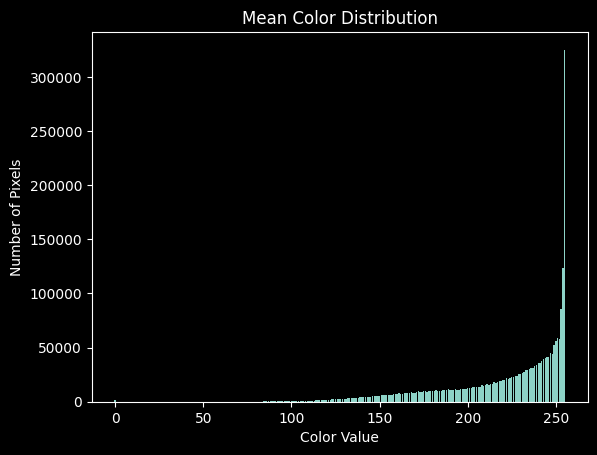

In [115]:
import matplotlib.pyplot as plt

# Calculate the mean color distribution across all images
mean_color_distribution = np.mean(color_distributions, axis=0)

# Plot a bar chart of the mean color distribution
plt.bar(np.arange(256), mean_color_distribution)
plt.title("Mean Color Distribution")
plt.xlabel("Color Value")
plt.ylabel("Number of Pixels")
plt.show()